In [28]:
import pandas as pd
import numpy as np
import spacy
import random
import nltk
import re
from matplotlib import pyplot as plt
import pathlib
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [30]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [31]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 300)
df.columns = ['id', 'title', 'genre', 'description']
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 300)
df2.columns = ['id', 'title', 'genre', 'description']

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd '/content/drive/My Drive/Colab Notebooks/[2022.1] PLN'

/content/drive/My Drive/Colab Notebooks/[2022.1] PLN


In [32]:
df3 = pd.concat([df, df2], ignore_index=True)
df3.drop('id', axis=1, inplace=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [33]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) 
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) 

In [34]:
dataset['processed_description'] = dataset.description.apply(preprocess)

In [35]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(description):
    tokenized_text = nltk.word_tokenize(description, language='english')
    return " ".join([token for token in tokenized_text if token not in stop_words])

In [36]:
dataset['processed_description_stop'] = dataset.processed_description.apply(remove_stopwords)

In [37]:
dataset

,title,genre,description,processed_description,processed_description_stop
0,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,in tough economic times max and joey have all...,tough economic times max joey run ideas discov...
1,Babylon Vista (2001),comedy,Frankie Reno was a child star on a TV show. B...,frankie reno was a child star on a tv show bu...,frankie reno child star tv show thirty years a...
2,Söderpojkar (1941),comedy,A gang of unemployed itinerant musicians play...,a gang of unemployed itinerant musicians play...,gang unemployed itinerant musicians play south...
3,Tunnel Vision (1976),comedy,A committee investigating TV's first uncensor...,a committee investigating tvs first uncensore...,committee investigating tvs first uncensored n...
4,"""The Young Professionals"" (2015)",comedy,"Whether it's blocking up mouse holes, running...",whether its blocking up mouse holes running f...,whether blocking mouse holes running landlords...
...,...,...,...,...,...
230,Future Weather (2012),drama,"When her single mom runs off to California, L...",when her single mom runs off to california la...,single mom runs california lauduree passionate...
231,Six Minutes to Midnight (????),drama,Summer 1939. Influential families in Nazi Ger...,summer influential families in nazi germany h...,summer influential families nazi germany sent ...
232,Jeunes filles en détresse (1939),drama,Jacqueline is sixteen. Her parents are kept v...,jacqueline is sixteen her parents are kept ve...,jacqueline sixteen parents kept busy mutual ca...
233,Silence (2013/XI),drama,'Silence' is an intimate portrait of the life...,silence is an intimate portrait of the life o...,silence intimate portrait life ten year old gi...


## Questão 3
Usando sua base de textos:

a) Treine uma rede LSTM para gerar texto, que receba uma ou mais palavras
de uma frase como entrada. O treinamento deve ser realizado considerando
um conjunto supervisionado que gera a próxima palavra de uma sequência
de tamanho 4, usando subsequências de sua base.

b) Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 10 palavras consecutivamente.

In [38]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(description):
    tokenizer.fit_on_texts(dataset.processed_description)
    total_words = len(tokenizer.word_index) + 1

    input_sequences = []
    for line in description:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(dataset.processed_description)

In [39]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [40]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length=input_len))
  
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 660, 10)           57310     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5731)              578831    
                                                                 
Total params: 680,541
Trainable params: 680,541
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(predictors, label, epochs=11, verbose=1)

Epoch 1/11
750/750 [==============================] - 279s 369ms/step - loss: 7.2108
Epoch 2/11
750/750 [==============================] - 309s 412ms/step - loss: 6.8033
Epoch 3/11
750/750 [==============================] - 266s 354ms/step - loss: 6.6608
Epoch 4/11
750/750 [==============================] - 259s 346ms/step - loss: 6.5247
Epoch 5/11
750/750 [==============================] - 255s 340ms/step - loss: 6.3644
Epoch 6/11
750/750 [==============================] - 262s 349ms/step - loss: 6.2139
Epoch 7/11
750/750 [==============================] - 284s 379ms/step - loss: 6.0417
Epoch 8/11
750/750 [==============================] - 285s 380ms/step - loss: 5.8411
Epoch 9/11
750/750 [==============================] - 268s 357ms/step - loss: 5.6350
Epoch 10/11
750/750 [==============================] - 255s 339ms/step - loss: 5.4178
Epoch 11/11
750/750 [==============================] - 253s 338ms/step - loss: 5.2118


In [42]:
def generate_text(seed_text, next_words, model, max_sequence_len): 
    #seed_text: string para teste, next_word: qtdd de palavras q quer prever, max_sequence_len: contagem max de seq usada durante o treinamento
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = model.predict(token_list) 
        classes = np.argmax(predicted,axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == classes:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [43]:
print (generate_text("frankie reno was a child", 4, model, max_sequence_len))

1/1 [==============================] - 0s 31ms/step
Frankie Reno Was A Child Of A Single Man


In [44]:
print (generate_text("whether its blocking up", 10, model, max_sequence_len))
print (generate_text("science and technology", 10, model, max_sequence_len))
print (generate_text("awake from a deep sleep", 10, model, max_sequence_len))
print (generate_text("first film", 10, model, max_sequence_len))
print (generate_text("the sydney opera house", 10, model, max_sequence_len))

1/1 [==============================] - 0s 32ms/step
Whether Its Blocking Up A Story Of A Single Man And A Series Of
1/1 [==============================] - 0s 37ms/step
Science And Technology To A Young Father Of A Series Of The Boy
1/1 [==============================] - 0s 29ms/step
Awake From A Deep Sleep In A Young Company Of A Series Of The Sisters
1/1 [==============================] - 0s 34ms/step
First Film A Story Of A Single Man Who Is A Series
1/1 [==============================] - 0s 34ms/step
The Sydney Opera House In A Beautiful Family And A Monte Mihai Teenager Who


## Questão 4
Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:

a) Extraia as etiquetas gramaticais (POS) de cada token do seu textos.

b) Calcule e plote um gráfico com as frequências de cada tipo gramatical.

c) Extraia entidades do tipo pessoa e lugar dos seus textos.

d) Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.

In [45]:
nlp = spacy.load("en_core_web_sm")

In [46]:
processed_description_list = list(dataset['processed_description_stop'].values)

In [47]:
token_pos = []

for phrase in processed_description_list:
    doc = nlp(phrase)

    for token in doc:        
        token_pos.append(token.pos_)

token_pos[:20]

['ADJ',
 'ADJ',
 'NOUN',
 'PROPN',
 'PROPN',
 'VERB',
 'NOUN',
 'VERB',
 'ADJ',
 'NOUN',
 'PROPN',
 'PROPN',
 'PROPN',
 'VERB',
 'PROPN',
 'PRON',
 'VERB',
 'CCONJ',
 'ADJ',
 'NOUN']

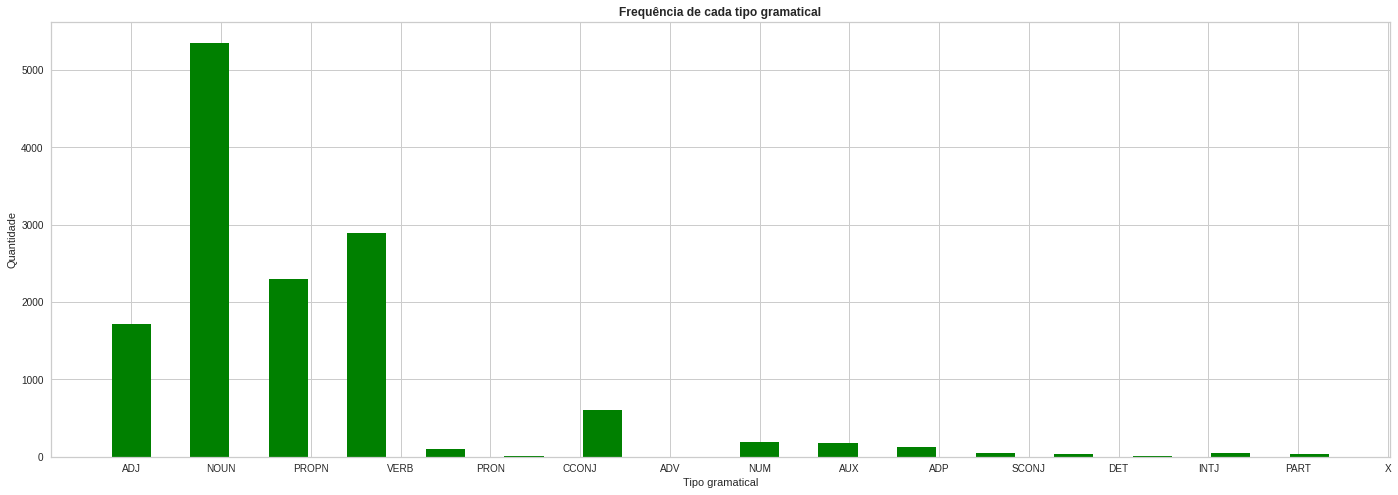

In [48]:
plt.figure(figsize=(24,8))
plt.hist(token_pos, bins=16, rwidth=0.5, align='left', color='green')

plt.xlabel('Tipo gramatical')
plt.ylabel('Quantidade')
  
plt.title('Frequência de cada tipo gramatical',
          fontweight ="bold")
  
plt.show()

In [49]:
entities_person_gpe = []
persons = {}
entities_to_search = ['PERSON', 'GPE']

for phrase in processed_description_list:
    doc = nlp(phrase)

    for entity in doc.ents:
      entity_persons_in_doc = []

    if entity.label_ in entities_to_search:
      entities_person_gpe.append((entity.text, entity.label_))
      
      if entity.label_ == 'PERSON':
          entity_persons_in_doc.append(entity.text)
      
      unique_persons = list(set(entity_persons_in_doc))
      
      for unique_person in unique_persons:
        if unique_person in persons.keys():
          persons[unique_person] += 1
        else:
          persons[unique_person] = 1

In [50]:
entities_person_gpe[:20]

[('juvet', 'PERSON'),
 ('las vegas', 'GPE'),
 ('billie van peteghem', 'PERSON'),
 ('herbert marshall intervene try', 'PERSON'),
 ('kenny doug', 'PERSON'),
 ('dean charles drunken', 'PERSON'),
 ('joe', 'PERSON'),
 ('joe', 'PERSON'),
 ('new york city', 'GPE'),
 ('chris', 'PERSON'),
 ('kim', 'PERSON'),
 ('john michael', 'PERSON'),
 ('susan crush', 'PERSON'),
 ('marisa molto bella', 'PERSON'),
 ('ira knowledge', 'PERSON'),
 ('joe', 'PERSON'),
 ('monica', 'PERSON'),
 ('mike', 'PERSON'),
 ('vasu inamdar', 'PERSON'),
 ('brad johnson', 'PERSON')]

In [51]:
get_entities = list([ent[1] for ent in entities_person_gpe])

[(entity, get_entities.count(entity)) for entity in set(get_entities)]

[('PERSON', 73), ('GPE', 21)]

In [52]:
most_frequent_persons = [(key, value) for key, value in persons.items()]
most_frequent_persons.sort(key= lambda person : person[1], reverse=True)
most_frequent_persons[:10]

[('joe', 3),
 ('darren', 3),
 ('ben', 3),
 ('rani', 2),
 ('rachael', 2),
 ('jeanne ideal', 2),
 ('rick jos', 2),
 ('joseph', 2),
 ('rcmp officer', 2),
 ('juvet', 1)]